In [140]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(1337)
torch.manual_seed(1337)

In [2]:
NUM_USERS = 943
NUM_MOVIES = 1682
BATCH_SIZE = 64

num_user_features = 24
num_movie_features = 19

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
path = '../data/preprocessed/'

in_file = open(path + 'user_features.pickle', 'rb')
user_features = pickle.load(in_file)
for key, val in user_features.items():
    user_features[key] = torch.tensor(val.astype(np.float32))
in_file.close()

in_file = open(path + 'movie_features.pickle', 'rb')
movie_features = pickle.load(in_file)
for key, val in movie_features.items():
    movie_features[key] = torch.tensor(val.astype(np.float32))
in_file.close()

In [4]:
path = '../data/preprocessed/train/'

in_file = open(path + 'user_metapaths.pickle', 'rb')
train_user_metapaths = pickle.load(in_file)
in_file.close()

in_file = open(path + 'movie_metapaths.pickle', 'rb')
train_movie_metapaths = pickle.load(in_file)
in_file.close()

train_pos = np.load(path + 'train_pos.npy')

In [5]:
path = '../data/preprocessed/test/'

in_file = open(path + 'user_metapaths.pickle', 'rb')
test_user_metapaths = pickle.load(in_file)
in_file.close()

in_file = open(path + 'movie_metapaths.pickle', 'rb')
test_movie_metapaths = pickle.load(in_file)
in_file.close()

test_pos = np.load(path + 'test_pos.npy')

In [107]:
class UserMovieDataset(Dataset):
    def __init__(self, positives, user_metapaths, movie_metapaths, max_user_size, max_movie_size, benchmark=False):

        self.max_user_size = max_user_size
        self.max_movie_size = max_movie_size

        self.user_metapaths = user_metapaths
        self.movie_metapaths = movie_metapaths
        self.merge_metapaths()

        if not benchmark:
            self.pos = positives
            self.sample_negatives()

            self.data = torch.tensor(np.vstack([self.pos, self.neg]))
            self.labels = torch.vstack([torch.ones((len(self.pos), 1)), torch.zeros((len(self.neg), 1))])
        else:
            self.data = torch.tensor(positives[:, :2])
            self.labels = torch.tensor(positives[:, 2])

    def sample_negatives(self):
        self.neg = []
        for i in tqdm(range(len(self.pos)), desc='Sampling negative edges'):
            user_id = np.random.randint(NUM_USERS)
            movie_id = np.random.randint(NUM_MOVIES)
            while ([user_id, movie_id] not in self.pos and \
                    [user_id, movie_id] not in self.neg) or \
                    len(self.user_metapaths[user_id]) == 0 or \
                    len(self.movie_metapaths[movie_id]) == 0:
                user_id = np.random.randint(NUM_USERS)
                movie_id = np.random.randint(NUM_MOVIES)
            self.neg.append([user_id, movie_id])
        self.neg = np.array(self.neg)

    def merge_metapaths(self):
        for key, val in tqdm(self.user_metapaths.items(), desc='Extracting user metapaths'):
            if len(self.user_metapaths[key]) > 0:
                self.user_metapaths[key] = [torch.vstack([user_features[i] for i in val[:, 0]])[:self.max_user_size], 
                                            torch.vstack([movie_features[i] for i in val[:, 1]])[:self.max_user_size], 
                                            torch.vstack([user_features[i] for i in val[:, 2]])[:self.max_user_size]]
                while len(self.user_metapaths[key][0]) < self.max_user_size:
                    self.user_metapaths[key][0] = torch.vstack([self.user_metapaths[key][0], torch.zeros_like(self.user_metapaths[key][0][0])])
                    self.user_metapaths[key][1] = torch.vstack([self.user_metapaths[key][1], torch.zeros_like(self.user_metapaths[key][1][0])])
                    self.user_metapaths[key][2] = torch.vstack([self.user_metapaths[key][2], torch.zeros_like(self.user_metapaths[key][2][0])])
                
            
        for key, val in tqdm(self.movie_metapaths.items(), desc='Extracting movie metapaths'):
            if len(self.movie_metapaths[key]) > 0:
                self.movie_metapaths[key] = [torch.vstack([movie_features[i] for i in val[:, 0]])[:self.max_movie_size],
                                            torch.vstack([user_features[i] for i in val[:, 1]])[:self.max_movie_size],
                                            torch.vstack([movie_features[i] for i in val[:, 2]])[:self.max_movie_size]]
                while len(self.movie_metapaths[key][0]) < self.max_movie_size:
                    self.movie_metapaths[key][0] = torch.vstack([self.movie_metapaths[key][0], torch.zeros_like(self.movie_metapaths[key][0][0])])
                    self.movie_metapaths[key][1] = torch.vstack([self.movie_metapaths[key][1], torch.zeros_like(self.movie_metapaths[key][1][0])])
                    self.movie_metapaths[key][2] = torch.vstack([self.movie_metapaths[key][2], torch.zeros_like(self.movie_metapaths[key][2][0])])

    def __getitem__(self, idx):
        user_id, movie_id = self.data[idx]
        return self.data[idx], self.labels[idx], *self.user_metapaths[user_id.item()], *self.movie_metapaths[movie_id.item()]

    def __len__(self):
        return len(self.data)

In [7]:
print('Train Dataset:')
train_dataset = UserMovieDataset(train_pos, train_user_metapaths, train_movie_metapaths, 5931, 3789)
print('Test Dataset:')
test_dataset = UserMovieDataset(test_pos, test_user_metapaths, test_movie_metapaths, 100, 41)

Train Dataset:


Sampling negative edges: 100%|██████████| 49906/49906 [00:18<00:00, 2674.27it/s]


Test Dataset:


Sampling negative edges: 100%|██████████| 5469/5469 [00:00<00:00, 9924.91it/s] 


In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [79]:
class GraphAttention(nn.Module):
    def __init__(self, 
                 hidden_dim,
                 num_heads,
                 dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        weighted, _ = self.attention(queries, keys, values)
        return weighted

class MetapathEncoder(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim, 
                ):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, metapath):
        x = torch.mean(metapath, dim=1)
        return self.fc(x)

class MAGNN(nn.Module):
    def __init__(self,
                 num_user_features,
                 num_movie_features,
                 hidden_dim,
                 out_dim,
                 num_heads,
                 dropout,
                 batch_size
                 ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.num_user_features = num_user_features
        self.num_movie_features = num_movie_features

        self.user_feature_encoder = nn.Linear(self.num_user_features, hidden_dim)
        self.movie_feature_encoder = nn.Linear(self.num_movie_features, hidden_dim)

        self.user_metapath_encoder = MetapathEncoder(hidden_dim, hidden_dim)
        self.user_metapath_attention = GraphAttention(hidden_dim, num_heads, dropout)

        self.movie_metapath_encoder = MetapathEncoder(hidden_dim, hidden_dim)
        self.movie_metapath_attention = GraphAttention(hidden_dim, num_heads, dropout)

        self.user_node_embedding = nn.Linear(hidden_dim, out_dim)
        self.user_dropout = nn.Dropout(dropout)

        self.movie_node_embedding = nn.Linear(hidden_dim, out_dim, dropout)
        self.movie_dropout = nn.Dropout(dropout)

        self.recommender = nn.Linear(2 * out_dim, 1)

    def forward(self, edge, user_metapaths1, user_metapaths2, user_metapaths3, movie_metapaths1, movie_metapaths2, movie_metapaths3):

        user_metapath_isntance = torch.cat([
            self.user_feature_encoder(user_metapaths1),
            self.movie_feature_encoder(user_metapaths2),
            self.user_feature_encoder(user_metapaths3)
        ], dim=1)
        user_aggregated_metapath = F.tanh(self.user_metapath_encoder(user_metapath_isntance))
        user_aggregated_metapath = self.user_metapath_attention(user_aggregated_metapath)

        movie_metapath_isntance = torch.cat([
            self.movie_feature_encoder(movie_metapaths1),
            self.user_feature_encoder(movie_metapaths2),
            self.movie_feature_encoder(movie_metapaths3)
        ], dim=1)
        movie_aggregated_metapath = F.tanh(self.movie_metapath_encoder(movie_metapath_isntance))
        movie_aggregated_metapath = self.movie_metapath_attention(movie_aggregated_metapath)

        user_embed = self.user_dropout(F.sigmoid(self.user_node_embedding(user_aggregated_metapath)))
        movie_embed = self.movie_dropout(F.sigmoid(self.movie_node_embedding(movie_aggregated_metapath)))

        out = self.recommender(torch.cat([user_embed, movie_embed], dim=1))

        return F.sigmoid(out)

In [80]:
model = MAGNN(num_user_features=num_user_features, 
              num_movie_features=num_movie_features, 
              hidden_dim=128, 
              out_dim=128, 
              num_heads=8, 
              dropout=0.2,
              batch_size=BATCH_SIZE)

In [81]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-7)

In [82]:
def train(epoch):

    losses = []
    accs = []

    model.train()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

        optimizer.zero_grad()

        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE
        
        losses.append(loss.item())
        accs.append(acc.cpu())

        loss.backward()
        optimizer.step()

        progress_bar.set_description(f'Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}')

    return np.mean(losses)

def validate(epoch):
    losses = []
    accs = []

    model.eval()
    progress_bar = tqdm(test_loader)
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE
        
        losses.append(loss.item())
        accs.append(acc.cpu())

        progress_bar.set_description(f'Validation Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}')
    
    return np.mean(losses)

In [83]:
torch.cuda.empty_cache()

In [84]:
EPOCHS = 5
train_losses = []
val_losses = []
best_loss = 1e9
model.to(device)

for epoch in range(EPOCHS):
    train_loss = train(epoch)
    val_loss = validate(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print()
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), '../models/best_magnn.pt')

Epoch 0:   0%|          | 0/1560 [00:00<?, ?it/s]

Epoch 0, Loss: 0.69584, Acc: 0.49976, F1: 0.49534: 100%|██████████| 1560/1560 [04:05<00:00,  6.37it/s]
Validation Epoch 0, Loss: 0.69317, Acc: 0.49973, F1: 0.66488: 100%|██████████| 171/171 [00:02<00:00, 74.47it/s]


Epoch 1, Loss: 0.69541, Acc: 0.50131, F1: 0.49814: 100%|██████████| 1560/1560 [04:01<00:00,  6.45it/s]
Validation Epoch 1, Loss: 0.69319, Acc: 0.49973, F1: 0.00000: 100%|██████████| 171/171 [00:02<00:00, 76.74it/s]


Epoch 2, Loss: 0.60846, Acc: 0.64928, F1: 0.65806: 100%|██████████| 1560/1560 [04:01<00:00,  6.47it/s]
Validation Epoch 2, Loss: 0.59107, Acc: 0.70916, F1: 0.73243: 100%|██████████| 171/171 [00:02<00:00, 76.10it/s]


Epoch 3, Loss: 0.54069, Acc: 0.74485, F1: 0.77150: 100%|██████████| 1560/1560 [04:02<00:00,  6.44it/s]
Validation Epoch 3, Loss: 0.59015, Acc: 0.70623, F1: 0.73466: 100%|██████████| 171/171 [00:02<00:00, 78.36it/s]


Epoch 4, Loss: 0.53782, Acc: 0.74483, F1: 0.77128: 100%|██████████| 1560/1560 [04:01<00:00,  6.45it/s]
Validation Epoch 4, Loss: 0.58883, Acc: 0.70587, F1: 0.73707: 100%|██████████| 171/171 [00:02<00:00, 77.90it/s]

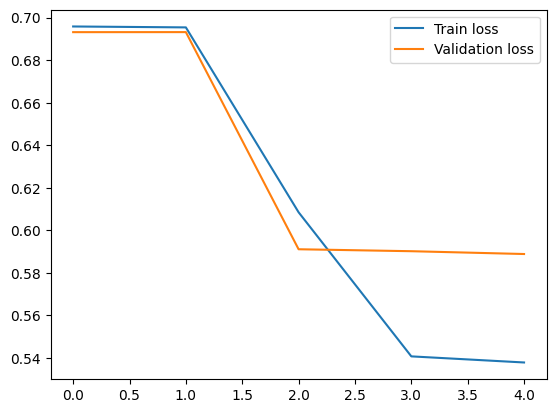

In [146]:
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.savefig('../reports/figures/losses.png')
plt.show()

In [116]:
path = '../benchmark/data/'

in_file = open(path + 'user_metapaths.pickle', 'rb')
benchmark_user_metapaths = pickle.load(in_file)
in_file.close()

in_file = open(path + 'movie_metapaths.pickle', 'rb')
benchmark_movie_metapaths = pickle.load(in_file)
in_file.close()

benchmark_data = np.load(path + 'benchmark_dataset.npy')

In [117]:
benchmark_dataset = UserMovieDataset(benchmark_data, benchmark_user_metapaths, benchmark_movie_metapaths, 100, 41, benchmark=True)

benchmark_loader = DataLoader(benchmark_dataset, batch_size=BATCH_SIZE)

Extracting movie metapaths: 100%|██████████| 1682/1682 [00:01<00:00, 1270.86it/s]


In [118]:
model = MAGNN(num_user_features=num_user_features, 
              num_movie_features=num_movie_features, 
              hidden_dim=128, 
              out_dim=128, 
              num_heads=8, 
              dropout=0.2,
              batch_size=BATCH_SIZE)
model.load_state_dict(torch.load('../models/best_magnn.pt'))

<All keys matched successfully>

In [138]:
model.to(device)
model.eval()

maps = []
accs = []

for batch in tqdm(benchmark_loader):
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
        edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

    out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)
    pred = (out > 0.5)
    acc = (pred == label.reshape(-1, 1)).sum() / BATCH_SIZE

    accs.append(acc.cpu())
    maps.append(average_precision_score(label.reshape(-1, 1).cpu().detach().numpy(), out.cpu().detach().numpy()))

print(f'mAP: {np.mean(maps)}')
print(f'Accuracy: {np.mean(accs)}')

100%|██████████| 1317/1317 [00:20<00:00, 64.21it/s]

mAP: 0.6351890012131759
Precission: 0.6037345383680619
Recall: 0.7888246242044944
Accuracy: 0.5938330292701721
